## Simulating data for Gaussian response distributions

### Simulating a hidden sequence

In [105]:
import numpy as np

# Number of components 
k = 2
# Timesteps t
T = 100
# Set seed
#np.random.seed(563)
# Transition matrix
g = np.array([[0.33, 0.67],
              [0.89, 0.11]])
# Initial states
pi = np.array([0.71, 0.29])
# mu / sd of the states
mu = np.array([9,14])
sd = np.array([2,4])
# Draw from one of the states with probability pi_i
np.random.multinomial(1, pi)
# Generate sequence
seq = np.zeros((T, 1), dtype = np.int32)
for t in range(T):
    if t == 0:
        seq[t,:] = int(np.nonzero(np.random.multinomial(1, pi))[0])
    else:
        seq[t,:] = int(np.nonzero(np.random.multinomial(1, np.dot(pi, np.linalg.matrix_power(g, t))))[0])
        
# Squeeze output
seq = seq.squeeze()

### Simulating observed data 

In [106]:
# Allocate
obs = np.zeros(T, dtype = np.float32)
# Set seed
#np.random.seed(886)
# Populate
for i in range(T):
    # Get state
    state = seq[i]
    # Draw from normal distribution
    obs[i] = np.round(np.random.normal(mu[state], sd[state]), 4)

/home/jasper/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


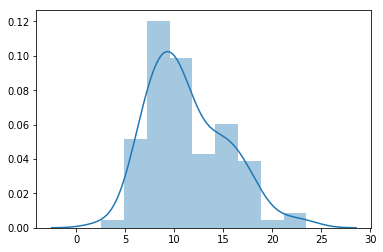

In [107]:
# Plot observed data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.distplot(obs)

## Estimating the state sequence

In [108]:
# Forward algorithm
from scipy.stats import norm

# We use the initial probabilities pi
# NOTE: we shouldn't really know these ...

# Initialize alpha using the initial distribution
alpha = pi
# Initialize states to 0
states = np.zeros(T, dtype = np.int32)
# For each observation and timestep t, compute the state using the forward algorithm
for t, x in enumerate(obs):
    # Compute probabilities for x at timestep t
    # Note that we are not assuming stationarity because we have alpha_1 = pi * P 
    #  at t == 1
    # Note that we are using population values mu and sd here
    p = norm.pdf(x, mu, sd)
    # Convert to diagonal matrix
    P = np.diag(p)
    # Form the matrix B
    B = np.dot(g, P)
    # Update alpha
    alpha = np.dot(alpha, B)
    # Add state
    states[t] = np.argmax(alpha)
    # At the last step, dot with 1' to get the likelihood
    if t == (T-1):
        L = np.dot(alpha, np.ones((k, 1), dtype = np.int32))

In [109]:
# Stack predicted and actual states column-wise
import pandas as pd
seqs = np.vstack((states,seq)).T
# Cast to data frame
print("First 10 observations ...")
pd.DataFrame(seqs, columns = ["predicted", "actual"]).head(10)

First 10 observations ...


,predicted,actual
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,0,1
6,0,0
7,1,0
8,0,0
9,0,1


In [110]:
# Print likelihood and alphas
print("Likelihood: {}".format(L))
print("Alphas at time T: {}".format(alpha))

Likelihood: [1.47601443e-126]
Alphas at time T: [8.78679240e-127 5.97335186e-127]


In the above implementation of the forward algorithm, clearly we are running into the issue of underflow. The values for the alphas are getting very small, and we need to start using some computational tricks to make sure we can handle longer sequences. See also chapt. 3.2 in Zucchini.

In [111]:
# Forward algorithm
from scipy.stats import norm

# Initialize alphas using the initial distribution
# scale the distribution by the sum of the alphas to prevent underflow
ones = np.ones((k, 1), dtype = np.int32)
phi = pi / np.dot(pi, ones) # ==> this is just scaling by 1 
# Initialize states to 0
states = np.zeros(T, dtype = np.int32)
# Initialize log-likelihood to 0
L = 0
# For each observation, compute the state using the forward algorithm
for t, x in enumerate(obs):
    # Compute probabilities for x at timestep t
    p = norm.pdf(x, mu, sd)
    # Convert to diagonal matrix
    P = np.diag(p)
    # Form the matrix B
    B = np.dot(g, P)
    # Create the vector v as the product of scaled alphas and B
    v = np.dot(phi, B)
    # Create the scalar u as the sum of the scaled alphas
    u = np.dot(v, ones)
    # Add to log-likelihood
    L += np.log(u)
    # Scale vector by the sum of v to create new phi
    phi = v / u
    # Add state
    states[t] = np.argmax(phi)

In [112]:
# Stack predicted and actual states column-wise
import pandas as pd
seqs = np.vstack((states,seq)).T
# Cast to data frame
print("First 10 observations ...")
pd.DataFrame(seqs, columns = ["predicted", "actual"]).head(10)

First 10 observations ...


,predicted,actual
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,0,1
6,0,0
7,1,0
8,0,0
9,0,1


In [113]:
# Print likelihood and alphas
print("Log-Likelihood: {}".format(L))
print("Phi at time T: {}".format(phi))

Log-Likelihood: [-289.73637622]
Phi at time T: [0.59530532 0.40469468]


In [114]:
def HMM_forward(X: np.array, pi: np.array, gamma: np.array, 
                mu: np.array, sd: np.array, return_states = False):
    
    """
    Compute the forward step of an HMM
    
    :param X: n x 1 numpy array containing the observed data
    :param pi: m x 1 numpy array containing initial values
    :param gamma: m x m numpy array containing transition probabilities
    :param mu: m x 1 numpy array containing means of component distributions
    :param sd: m x 1 numpy array containing sds of component distributions
    :param return_states: boolean. If True, then the state sequence is returned
    
    :return: Log-Likelihood and, if desired, the state sequence
    """
    
    # For dimensions
    m = mu.shape[0]
    T = X.shape[0]
    
    # Initialize alphas using the initial distribution
    # scale the distribution by the sum of the alphas to prevent underflow
    ones = np.ones((m, 1), dtype = np.int32)
    phi = pi 
    # Initialize states to 0
    if return_states: states = np.zeros(T, dtype = np.int32)
    # Initialize log-likelihood to 0
    L = 0
    # For each observation, compute the state using the forward algorithm
    for t, x in enumerate(X):
        # Compute probabilities for x at timestep t
        p = norm.pdf(x, mu, sd)
        # Convert to diagonal matrix
        P = np.diag(p)
        # Form the matrix B
        B = np.dot(gamma, P)
        # Create the vector v as the product of scaled alphas and B
        v = np.dot(phi, B)
        # Create the scalar u as the sum of the scaled alphas
        u = np.dot(v, ones)
        # Add to log-likelihood
        L += np.log(u)
        # Scale vector by the sum of v to create new phi
        phi = v / u
        # Add state
        if return_states: states[t] = np.argmax(phi)
        
    # Return
    if return_states:
        return((L, states))
    else:
        return(L)

## Optimization using an unconstrained optimizer

### Dealing with constraints

For the HMM with normal distribution we have no real constraints on the parameters $\mu_1, \mu_2, \sigma^2_1, \sigma^2_2$ since they are continuous and can take on any value. However, we have a constraint on the transition probability matrix $\pmb{\Gamma}$ because its rows must sum to one.

In [115]:
def transform_tpm(gamma: np.array) -> dict:
    
    """
    Transform the transition probability matrix gamma using the function g(x) = exp(x)
    """
    
    # Apply transformation of gamma
    # NOTE: have to reshape this as a column vector to make it compatible with R implementation
    tgamma = np.log(gamma / np.diag(gamma).reshape((gamma.shape[0],1)))
    # Retrieve off-diagonal elements
    # NOTE: have to reverse the nonzero elements to make it compatible with R implementation
    idx_tau = np.nonzero(tgamma)[::-1]
    # Retrieve nonzero elements
    tgamma_flat = tgamma[idx_tau]
    # Return values of transformation and indices
    return({"tgamma": tgamma_flat, "tgamma_idx": idx_tau})

def transform_tgamma(tgamma: dict) -> np.array:
    
    """
    Transform the transformed values of gamma back to probabilities
    """
    
    # Get values from dict
    tgamma, tgamma_idx = tgamma.values()
    # Identity matrix
    z = np.eye(tgamma_idx[0].shape[0])
    # Fill off-diagonal elements
    z[tgamma_idx] = np.exp(tgamma)
    # Scale
    z /= np.sum(z, axis=1).reshape((z.shape[0], 1))
    # Solve for delta (initial values)
    delta = np.linalg.solve((np.eye(z.shape[0]) - z + 1).T, np.ones(z.shape[0]))
    # Return
    return((z, delta))

In [116]:
# Transform the transition probability matrix
a = transform_tpm(g)
# Transform back and solve for delta
gam, delta = transform_tgamma(a)
# Print
print(gam)
print(delta)

[[0.33 0.67]
 [0.89 0.11]]
[0.57051282 0.42948718]


### Starting values

To assign starting values for the parameters, we can do the following:

1. For means, we can divide the observations into $k$ subsets using quartiles/quantiles and take the mean of the subsets.
2. For variances, we can take the variance of the $k$ subsets.
3. For initial transition probabilities, we can initialize the matrix $\pmb{\Gamma}$ using a uniform distribution with small values (e.g. 0.01 - 0.05) or initialize all values using the same, small value (e.g. 0.01).

In [117]:
# Initial values 
gamma = np.array([[1, 0.01],
                  [0.01, 1]])
# Split observed data at median
gr1 = obs[obs < np.median(obs)]
gr2 = obs[obs >= np.median(obs)]
# Construct means / variances
mu = np.array([np.mean(gr1), np.mean(gr2)])
sd = np.array([np.sqrt(np.var(gr1)), np.sqrt(np.mean(gr2))])

In [118]:
# Minimize function only takes a single array, so we need to add all parameters to a single array
tgamma, tgamma_idx = transform_tpm(gamma).values()
# Concatenate values to flat array
x0 = np.concatenate([tgamma, mu, sd])
x0

array([-4.60517019, -4.60517019,  8.20151138, 14.5022316 ,  1.56724155,
        3.80817962])

In [124]:
from scipy.optimize import minimize

def HMM(parameters: np.array, *args: tuple) -> float:
    
    """
    Given an array of parameters, compute the log-likelihood of the HMM
    
    :param parameters: parameters passed to the model. This is a single (flat)
                        numpy array whose valuese correspond to the following 
                        parameters:
                         (1) indices 0:(m*(m-1)) ==> transformed values of the 
                              transition matrix
                         (2) indices (m*(m-1)):[(m*(m-1))+m] ==> means of the 
                              component distributions
                         (3) indices [(m*(m-1))+m]:[(m*(m-1))+2*m] ==> variances
                              of the component distributions
    :param *args: additional parameters passed to the function:
                         (1) args[0] ==> number of components
                         (2) args[1] ==> tuple of numpy arrays used to transform
                                          the transformed gamma values back to
                                          their original form
                                          
    :return: Log-Likelihood of the model given the parameters
                                          
    :seealso: functions transform_tpm() and transform_tgamma() above
    
    :seealso: Zucchini, W., MacDonald, I. L., & Langrock, R. (2017). Hidden Markov 
                             models for time series: an introduction using R. 
                             Chapman and Hall/CRC. Chapters 2-3
    """
    
    # Args is the size of the 2x2 gamma matrix and the tgamma idices to backtransform to gamma
    m = args[0]
    tgamma_idx = args[1]
    
    # Unroll parameters
    tgamma = parameters[:(m*(m-1))]
    mu = parameters[(m*(m-1)):(m*(m-1)+m)]
    sd = parameters[(m*(m-1)+m):(m*(m-1)+2*m)]
    
    # Transform working parameters to natural parameters 
    # And solve for delta (initial values)
    gamma, pi = transform_tgamma({"tgamma": tgamma, "tgamma_idx": tgamma_idx})
    
    # Compute
    L = HMM_forward(obs, pi, gamma, mu, sd, return_states = False)
    
    # Return log-likelihood
    return( -1 * L[0] )

In [120]:
# Use optimize function from scipy
res = minimize(HMM, x0, args = (2, tgamma_idx), method = "BFGS",
               options = {'disp':True})

Optimization terminated successfully.
         Current function value: 268.264957
         Iterations: 23
         Function evaluations: 232
         Gradient evaluations: 29


In [121]:
# Transform gamma and pi
gamma, pi = transform_tgamma({"tgamma":res.x[:2], "tgamma_idx":tgamma_idx})
# Construct mu, sd
mu = res.x[2:4]
sd = res.x[4:6]

In [122]:
# Compute state sequences
_, states_pred = HMM_forward(obs, pi, gamma, mu, sd, return_states = True)

In [123]:
# Stack predicted and actual states column-wise
import pandas as pd
seqs = np.vstack((states_pred,seq)).T
# Cast to data frame
print("First 10 observations ...")
print("Steps correct: {}%".format(np.round(sum(states_pred == seq) / len(seq),4) * 100))
pd.DataFrame(seqs, columns = ["predicted", "actual"]).head(10)

First 10 observations ...
Steps correct: 79.0%


,predicted,actual
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,0,0
7,0,0
8,0,0
9,0,1


## Optimization using Expectation-Maximization (EM) 

The function below is a general, recursive function that can be used to compute the likelihood and state sequence.

In [ ]:
def HMM_EM(X: np.array, phi: np.array, gamma: np.array, k: int, **kwargs) -> tuple:
    
    """
    Use forward algorithm to compute the state sequence and Log-Likelihood
    
    :param X: Observed data
    :param phi: Initial distribution
    :param gamma: Transition Probability Matrix 
    :param k: Number of hidden states
    
    :return: tuple containing 
        (1) state sequence as T-dimensional array
        (2) Log-Likelihood
    """
    
    # Initialize alphas using the initial distribution
    # scale the distribution by the sum of the alphas to prevent underflow
    ones = np.ones((k, 1), dtype = np.int32)
    # If states not supplied, initialize them
    if kwargs.get("states") is None:
        # Initialize states to 0
        states = np.zeros(X.shape[0], dtype = np.int32)
    else:
        states = kwargs["states"]
    # Initialize log-likelihood to 0 if not passed
    if kwargs.get("L") is None:
        L = kwargs["L"]
    else:
        L = 0
        
    # ...
    pass